# Wasserstein GAN

## Ressources

[paper](https://arxiv.org/abs/1701.07875)

In [29]:
%matplotlib inline
import torch
from torch import optim, nn, FloatTensor as FT
import torch.nn.parallel
import torch.utils.data
from torch.backends import cudnn
from torchvision import datasets, transforms, utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

## Data

In [2]:
batch_size = 64
image_size = 64
noise_size = 100

In [3]:
PATH = '/home/mark/data/cifar10/'
data = datasets.CIFAR10(root=PATH, download=True,
                        transform=transforms.Compose([
                            transforms.Scale(image_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ]))

Files already downloaded and verified


In [4]:
# PATH = 'data/lsun/'
# data = datasets.LSUN(db_path=PATH, classes=['bedroom_train'],
#     transform=transforms.Compose([
#         transforms.Scale(sz),
#         transforms.CenterCrop(sz),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ]))

In [5]:
dataloader = torch.utils.data.DataLoader(data, batch_size, shuffle=True, num_workers=8)
n = len(dataloader); n

782

## Train

In [33]:
def show(img, figsize=(16,16)):
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

### DCGAN

#### Generator (G)

In [7]:
class DCGAN_G(nn.Module):
    def deconv_block(self, main, name, inf, of, a, b, c, bn=True):
        main.add_module(f'{name}-{inf}.{of}.convt', nn.ConvTranspose2d(inf, of, a, b, c, bias=False))
        main.add_module(f'{name}-{of}.batchnorm', nn.BatchNorm2d(of))
        main.add_module(f'{name}-{of}.relu', nn.ReLU(inplace=True))
    
    def __init__(self, isize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(DCGAN_G, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, 'isize has to be a multiple of 16'
        
        cngf, tisize = ngf//2, 4
        while tisize != isize: cngf *= 2; tisize *= 2
            
        main = nn.Sequential()
        self.deconv_block(main, 'initial', nz, cngf, 4, 1, 0)
        
        cndf, csize = cngf, 4
        while csize < isize//2:
            self.deconv_block(main, 'pyramid', cngf, cngf//2, 4, 2, 1)
            cngf //= 2;
            csize *= 2
        
        for t in range(n_extra_layers):
            self.deconv_block(main, f'extra-{t}', cngf, cngf, 3, 1, 1)
        
        main.add_module(f'final.{cngf}-{nc}.convt', nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module(f'final.{nc}.tanh', nn.Tanh())
        self.main = main
    
    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        return nn.parallel.data_parallel(self.main, input, gpu_ids)

#### Discriminator (D)

In [8]:
class DCGAN_D(nn.Module):
    def conv_block(self, main, name, inf, of, a, b, c, bn=True):
        main.add_module(f'{name}-{inf}.{of}.conv', nn.Conv2d(inf, of, a, b, c, bias=False))
        main.add_module(f'{name}-{of}.batchnorm', nn.BatchNorm2d(of))
        main.add_module(f'{name}-{of}.relu', nn.LeakyReLU(0.2, inplace=True))
        
    def __init__(self, isize, nc, ndf, ngpu, n_extra_layers=0):
        super(DCGAN_D, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, 'isize has to be a multiple of 16'
        
        main = nn.Sequential()
        # input is nc * isize * isize
        self.conv_block(main, 'initial', nc, ndf, 4, 2, 1, bn=False)
        csize, cndf = isize /2, ndf
        
        for t in range(n_extra_layers):
            self.conv_block(main, f'extra-{t}', cndf, cndf, 3, 1, 1)
            
        while csize > 4:
            self.conv_block(main, 'pyramid', cndf, cndf*2, 4, 2, 1)
            cndf *= 2
            csize /= 2
        
        # state size. K * 4 * 4
        main.add_module(f'final.{cndf}-1.conv', nn.Conv2d(cndf, 1, 4, 1, 0, bias=True))
        self.main = main
    
    def forward(self, input):
        gpu_ids = None
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            gpu_ids = range(self.ngpu)
        output = nn.parallel.data_parallel(self.main, input, gpu_ids)
        output = output.mean(0)
        return output.view(1)

#### Model

In [9]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
netG = DCGAN_G(image_size, noise_size, 3, 64, 1, 1).cuda()
netG.apply(weights_init)

DCGAN_G (
  (main): Sequential (
    (initial-100.512.convt): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial-512.batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (initial-512.relu): ReLU (inplace)
    (pyramid-512.256.convt): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-256.relu): ReLU (inplace)
    (pyramid-256.128.convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-128.relu): ReLU (inplace)
    (pyramid-128.64.convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-64.relu): ReLU (inplace)
    (extra-0-64.64.convt

In [11]:
netD = DCGAN_D(image_size, 3, 64, 1, 1).cuda()
netD.apply(weights_init)

DCGAN_D (
  (main): Sequential (
    (initial-3.64.conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (initial-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (initial-64.relu): LeakyReLU (0.2, inplace)
    (extra-0-64.64.conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (extra-0-64.batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (extra-0-64.relu): LeakyReLU (0.2, inplace)
    (pyramid-64.128.conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-128.relu): LeakyReLU (0.2, inplace)
    (pyramid-128.256.conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid-256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid-256.relu): LeakyReLU (0.2, inplace)
    (pyramid-256.512.

Shortcuts to create tensors and variables

In [12]:
from torch import FloatTensor as FT
def Var(*params): return Variable(FT(*params).cuda())

In [13]:
def create_noise(batch_size, noise_size):
    return Variable(FT(batch_size, noise_size, 1, 1).cuda().normal_(0, 1))

In [14]:
inp = Var(batch_size, 3, image_size, noise_size)
# fixed noise for visualizing images
fixed_noise = create_noise(batch_size, noise_size)
# numbers 1 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

Optimizer

In [15]:
optimizerD = optim.RMSprop(netD.parameters(), lr=1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr=1e-4)

forward and backward step for discriminator (D)

In [16]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [17]:
def make_trainable(net, val):
    for p in net.parameters(): p.requires_grad = val

In [24]:
def train(epochs, first=True):
    gen_iterations = 0
    for epoch in range(epochs):
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25)
                       or gen_iterations % 500 == 0
                       else 5)
            j = 0
            while j < d_iters and i < n:
                j += 1
                i += 1
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter)[0].cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0], noise_size))
                inp.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(inp, mone)
                errD = errD_real - errD_fake
                optimizerD.step()
            
            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(batch_size, noise_size)), one)
            optimizerG.step()
            gen_iterations += 1
        print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
            epoch, epochs, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))

In [25]:
%time train(200, True)

[0/200][8/782] Loss_D: -1.499566 Loss_G: 0.717732 Loss_D_real: -0.788446 Loss_D_fake 0.711120
[1/200][16/782] Loss_D: -1.208674 Loss_G: 0.589842 Loss_D_real: -0.534358 Loss_D_fake 0.674316
[2/200][24/782] Loss_D: -1.413287 Loss_G: 0.673822 Loss_D_real: -0.734945 Loss_D_fake 0.678342
[3/200][162/782] Loss_D: -1.433053 Loss_G: 0.683340 Loss_D_real: -0.759179 Loss_D_fake 0.673874
[4/200][319/782] Loss_D: -1.005488 Loss_G: 0.551956 Loss_D_real: -0.568062 Loss_D_fake 0.437426
[5/200][476/782] Loss_D: -0.865832 Loss_G: 0.365511 Loss_D_real: -0.284136 Loss_D_fake 0.581696
[6/200][614/782] Loss_D: -0.984981 Loss_G: 0.555352 Loss_D_real: -0.649534 Loss_D_fake 0.335447
[7/200][771/782] Loss_D: -1.259802 Loss_G: 0.587882 Loss_D_real: -0.670827 Loss_D_fake 0.588975
[8/200][928/782] Loss_D: -0.871406 Loss_G: 0.608123 Loss_D_real: -0.705380 Loss_D_fake 0.166026
[9/200][1066/782] Loss_D: -0.458060 Loss_G: 0.624254 Loss_D_real: -0.683384 Loss_D_fake -0.225325
[10/200][1223/782] Loss_D: -0.678738 Loss_

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f002c6265f8>>
Traceback (most recent call last):
  File "/home/mark/.conda/envs/dl/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 241, in __del__
    self._shutdown_workers()
  File "/home/mark/.conda/envs/dl/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 237, in _shutdown_workers
    self.index_queue.put(None)
  File "/home/mark/.conda/envs/dl/lib/python3.6/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/home/mark/.conda/envs/dl/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/mark/.conda/envs/dl/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/mark/.conda/envs/dl/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._h

[25/200][3501/782] Loss_D: -1.410716 Loss_G: 0.676304 Loss_D_real: -0.752501 Loss_D_fake 0.658214
[26/200][3658/782] Loss_D: -0.969292 Loss_G: 0.564943 Loss_D_real: -0.555590 Loss_D_fake 0.413702
[27/200][3815/782] Loss_D: -1.445324 Loss_G: 0.698686 Loss_D_real: -0.762831 Loss_D_fake 0.682493
[28/200][3972/782] Loss_D: -0.396530 Loss_G: -0.242045 Loss_D_real: 0.083329 Loss_D_fake 0.479859
[29/200][4110/782] Loss_D: -0.404267 Loss_G: 0.402733 Loss_D_real: 0.228447 Loss_D_fake 0.632714
[30/200][4267/782] Loss_D: -0.695265 Loss_G: 0.630567 Loss_D_real: -0.645685 Loss_D_fake 0.049580
[31/200][4424/782] Loss_D: -0.390435 Loss_G: 0.048302 Loss_D_real: 0.260479 Loss_D_fake 0.650914
[32/200][4562/782] Loss_D: -1.453297 Loss_G: 0.698518 Loss_D_real: -0.767865 Loss_D_fake 0.685432
[33/200][4719/782] Loss_D: -0.598482 Loss_G: 0.607439 Loss_D_real: -0.733830 Loss_D_fake -0.135348
[34/200][4876/782] Loss_D: -1.353851 Loss_G: 0.653695 Loss_D_real: -0.721434 Loss_D_fake 0.632417
[35/200][5014/782] Lo

[109/200][16232/782] Loss_D: -0.670802 Loss_G: 0.118235 Loss_D_real: -0.152024 Loss_D_fake 0.518778
[110/200][16389/782] Loss_D: -0.849202 Loss_G: 0.593555 Loss_D_real: -0.513828 Loss_D_fake 0.335374
[111/200][16527/782] Loss_D: -0.723330 Loss_G: 0.545836 Loss_D_real: -0.524415 Loss_D_fake 0.198915
[112/200][16684/782] Loss_D: -0.770007 Loss_G: 0.110633 Loss_D_real: -0.309637 Loss_D_fake 0.460370
[113/200][16841/782] Loss_D: -0.724789 Loss_G: 0.426866 Loss_D_real: -0.426635 Loss_D_fake 0.298155
[114/200][16998/782] Loss_D: -0.719979 Loss_G: 0.395811 Loss_D_real: -0.421255 Loss_D_fake 0.298724
[115/200][17136/782] Loss_D: -0.683886 Loss_G: 0.590454 Loss_D_real: -0.649000 Loss_D_fake 0.034886
[116/200][17293/782] Loss_D: -0.689963 Loss_G: 0.261892 Loss_D_real: -0.138567 Loss_D_fake 0.551396
[117/200][17450/782] Loss_D: -0.256830 Loss_G: 0.427181 Loss_D_real: -0.563527 Loss_D_fake -0.306697
[118/200][17588/782] Loss_D: -0.230552 Loss_G: 0.337515 Loss_D_real: -0.514280 Loss_D_fake -0.28372

[191/200][28658/782] Loss_D: -0.465879 Loss_G: 0.451309 Loss_D_real: -0.231083 Loss_D_fake 0.234796
[192/200][28815/782] Loss_D: -0.691890 Loss_G: 0.017066 Loss_D_real: -0.214476 Loss_D_fake 0.477414
[193/200][28972/782] Loss_D: -0.459458 Loss_G: 0.489264 Loss_D_real: -0.591656 Loss_D_fake -0.132199
[194/200][29110/782] Loss_D: -0.459347 Loss_G: 0.165551 Loss_D_real: 0.089334 Loss_D_fake 0.548681
[195/200][29267/782] Loss_D: -0.817668 Loss_G: 0.077404 Loss_D_real: -0.324445 Loss_D_fake 0.493223
[196/200][29424/782] Loss_D: -0.736086 Loss_G: 0.616182 Loss_D_real: -0.577095 Loss_D_fake 0.158990
[197/200][29562/782] Loss_D: -0.316184 Loss_G: 0.321748 Loss_D_real: -0.517908 Loss_D_fake -0.201724
[198/200][29719/782] Loss_D: -0.644129 Loss_G: 0.546498 Loss_D_real: -0.605158 Loss_D_fake 0.038972
[199/200][29876/782] Loss_D: -0.696959 Loss_G: 0.516752 Loss_D_real: -0.497506 Loss_D_fake 0.199453
CPU times: user 1h 10min 16s, sys: 14min, total: 1h 24min 17s
Wall time: 1h 25min 29s


## Results

In [30]:
fake = netG(fixed_noise).data.cpu()

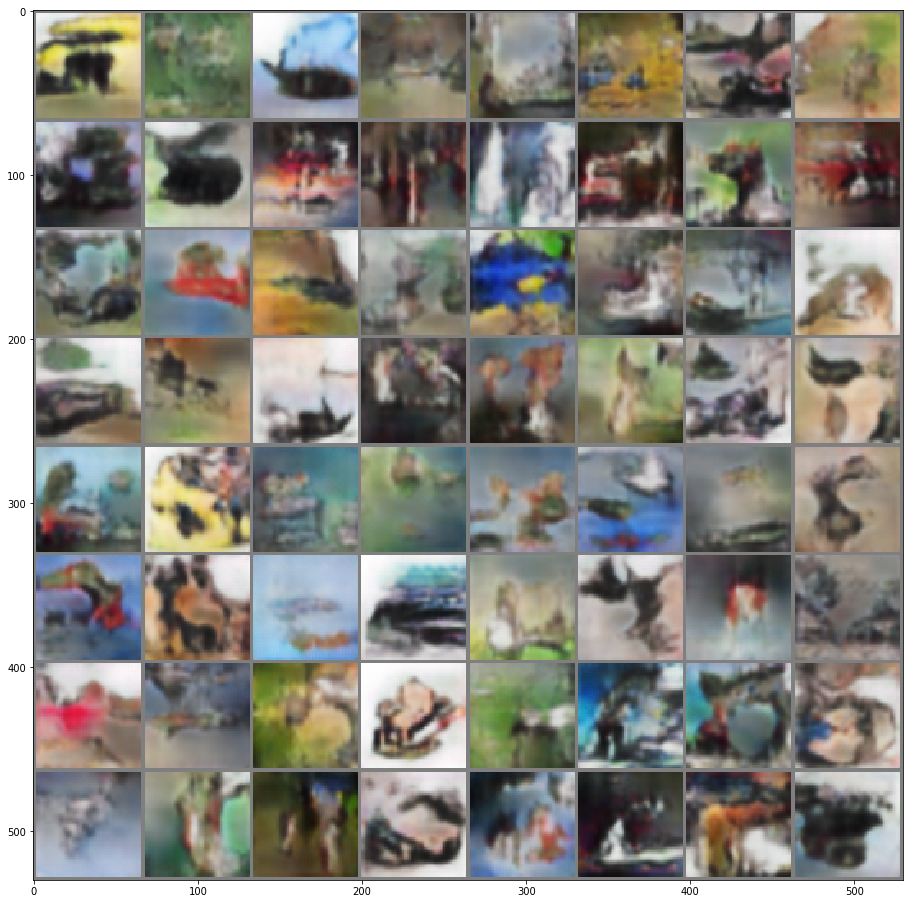

In [34]:
show(vutils.make_grid(fake))

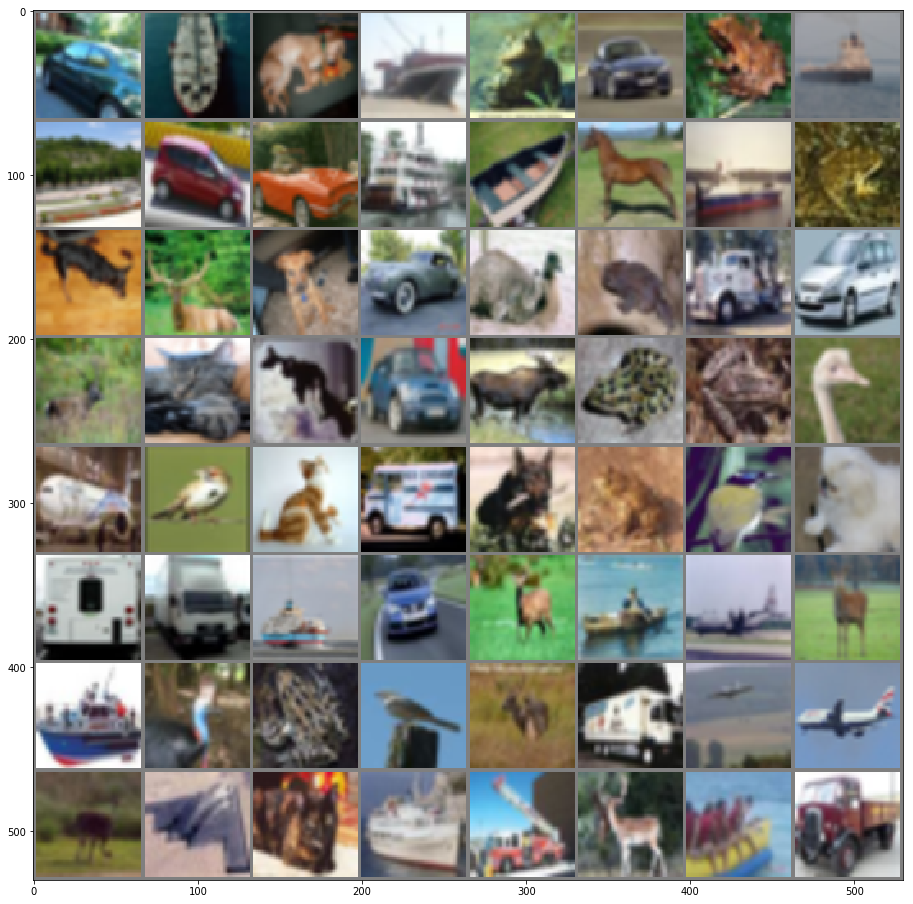

In [35]:
show(vutils.make_grid(iter(dataloader).next()[0]))